<a href="https://colab.research.google.com/github/SujalChauhan04/Generative-AI-labfile/blob/main/Experiment-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
# Load MNIST data
(X_train,_), (_, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [9]:
# Normalize data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


In [10]:
def build_discriminator():
 model = Sequential()

 # Conv2D layer with 64 filters, kernel size 4x4, stride 2, padding same (no activation)
 model.add(Conv2D(64, (4,4), strides=2, padding="same", input_shape=(28,28,1)))
 # LeakyReLU activation with negative_slope 0.2
 model.add(LeakyReLU(0.2))
 # Conv2D layer with 128 filters, kernel size 4x4, stride 2, padding same (no activation)
 model.add(Conv2D(128, (4,4), strides=2, padding="same"))
 # LeakyReLU activation with negative_slope 0.2
 model.add(LeakyReLU(0.2))
 # Flatten layer
 model.add(Flatten())
 # Final Dense layer with sigmoid activation
 model.add(Dense(1, activation="sigmoid"))
 return model
# Compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,
beta_1=0.5), metrics=['accuracy'])
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 138561 (541.25 KB)
Trainable params: 13856

In [11]:
#The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers
#to produce an image from a seed (random noise).
def build_generator():
 model = Sequential()
 # Dense layer with 7 * 7 * 128 units, input_dim=100, no activation
 model.add(Dense(7*7*128, input_dim=100))
 # LeakyReLU activation with negative_slope 0.2
 model.add(LeakyReLU(0.2))
 # Reshape output to (7, 7, 128)
 model.add(Reshape((7, 7, 128)))
 # Conv2DTranspose with 64 filters, kernel size 4x4, stride 2, same padding
 model.add(Conv2DTranspose(64, (4,4), strides=2, padding="same"))
 # LeakyReLU activation with negative_slope 0.2
 model.add(LeakyReLU(0.2))
 # Conv2DTranspose with 1 filter, kernel size 4x4, stride 2, same padding, tanh activation
 model.add(Conv2DTranspose(1, (4,4), strides=2, padding="same",
activation="tanh"))
 return model
# Combine generator and discriminator into a single model
generator = build_generator()
generator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 1)         1025      
 Transpose)                                           

In [12]:
# Input Latent Variable
z = Input(shape=(100,))
# Output of generator
img = generator(z)
# Freeze Discriminator
discriminator.trainable = False
# Give output of Generator to the Discriminator
validity = discriminator(img)
# Build DCGAN
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,
beta_1=0.5))
gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         765633    
                                                                 
 sequential (Sequential)     (None, 1)                 138561    
                                                                 
Total params: 904194 (3.45 MB)
Trainable params: 765633 (2.92 MB)
Non-trainable params: 138561 (541.25 KB)
_________________________________________________________________


In [18]:
# Train DCGAN
epochs = 5000
batch_size = 64
d_loss_all,g_loss_all=list(),list()
for epoch in range(epochs):
 # Select a random batch of images
 idx = np.random.randint(0, X_train.shape[0], batch_size) #generate a random number for selecting an image
 real_images = X_train[idx]
 # Generate fake images
 noise = np.random.normal(0, 1, (batch_size, 100)) # generate z
 fake_images = generator.predict(noise) # generator output for input z
 # Train discriminator
 d_loss_real = discriminator.train_on_batch(real_images,
np.ones(batch_size))
 d_loss_fake = discriminator.train_on_batch(fake_images,
np.zeros(batch_size))
 d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
 d_loss_all.append(d_loss[0])
 # Train generator
 noise = np.random.normal(0, 1, (batch_size, 100))
 g_loss = gan.train_on_batch(noise, np.ones(batch_size))
 g_loss_all.append(g_loss)
 # Print progress
 if epoch % 1000 == 0:
  print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss[0]} \t Generator Loss: {g_loss}") # Removed [0] from g_loss

2/2 [==============================] - 0s 31ms/step
Epoch: 0 	 Discriminator Loss: 0.5751286149024963 	 Generator Loss: 1.8635512590408325
2/2 [==============================] - 0s 37ms/step
Epoch: 1000 	 Discriminator Loss: 0.6024713814258575 	 Generator Loss: 1.4090101718902588
2/2 [==============================] - 0s 29ms/step


KeyboardInterrupt: 

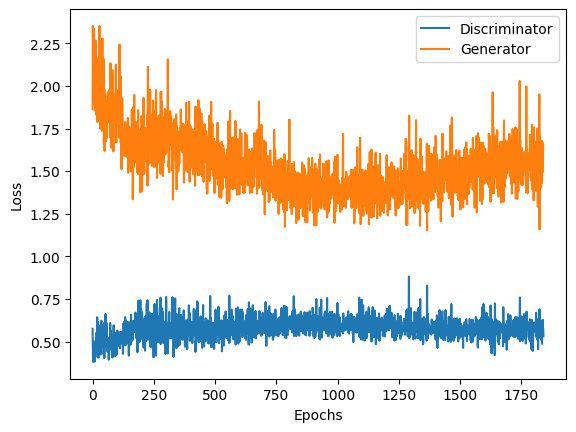

In [19]:
plt.plot(d_loss_all)
plt.plot(g_loss_all)
plt.legend(('Discriminator','Generator'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


4/4 [==============================] - 0s 15ms/step


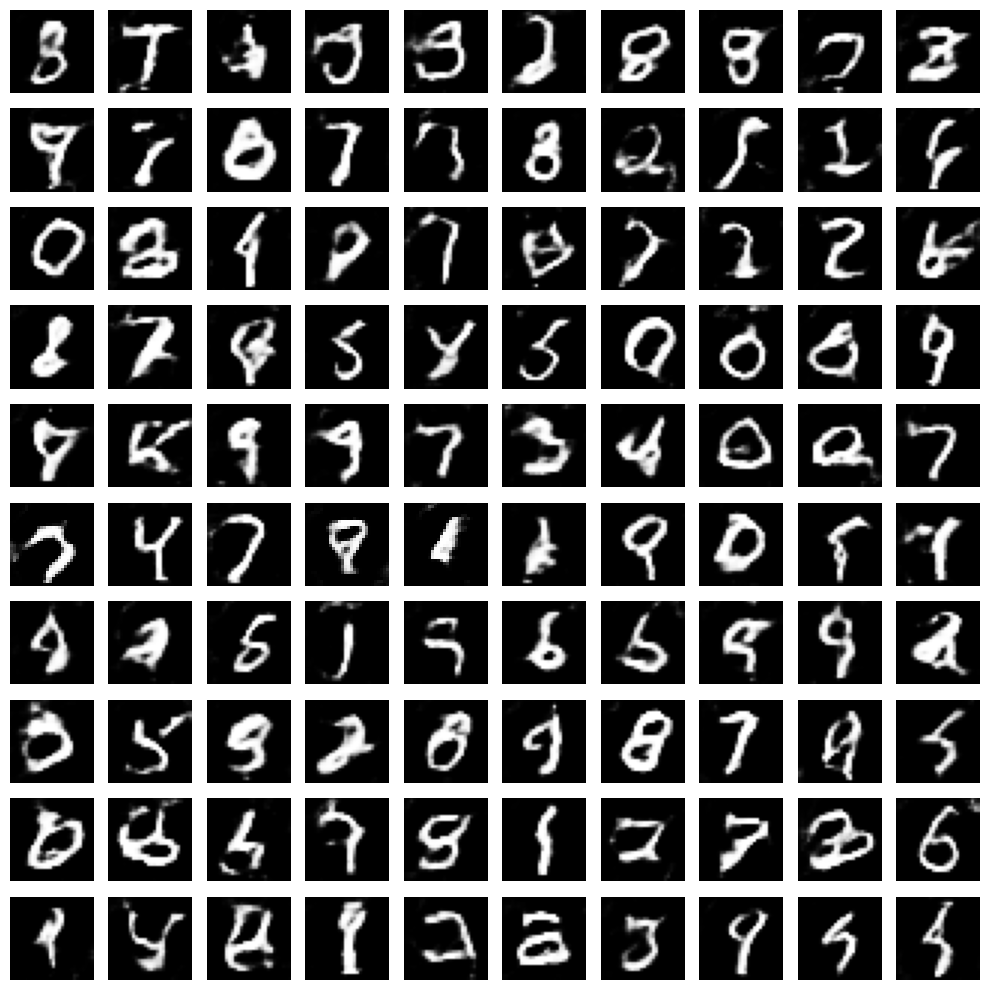

In [21]:
# Generate images
noise = np.random.normal(0, 1, (100, 100))
generated_images = generator.predict(noise)
# Display generated images
plt.figure(figsize=(10, 10))
for i in range(100):
 plt.subplot(10, 10, i+1)
 plt.imshow(generated_images[i, :, :, 0], cmap='gray')
 plt.axis('off')
plt.tight_layout()
plt.show()
